In [1]:
import sys
import collections
import os
import time

import torch as th
from torch import nn
from torch.utils.data import DataLoader, Dataset
import geoopt as gt

import numpy as np

import dill
import yaml
from tqdm import tqdm

from probe.euclid import *
from probe.hyper import *
from util.data import custom_pad
from util.loss import *
from util.evalu import *
from util.train import *

## Dataset

In [2]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

model_name = 'bert-base-cased'
layer_index = 7
data_dir = './data/dataset/'
dev_distance_dataset_path = os.path.join(data_dir, 
                                         'distance', 
                                         model_name, 
                                         'dev-layer-' + str(layer_index) + '.pt')
dev_dataset = th.load(dev_distance_dataset_path, pickle_module=dill)

## Visualization

In [3]:
%matplotlib inline

import random

import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.path import Path
import matplotlib.patches as patches

from util.viz import *

plt.style.use('default')
plt.rcParams["font.family"] = "DejaVu Serif"
mpl.rcParams['figure.dpi'] = 100

stop_words = ',.:;?()``\"\'\''

In [4]:
config_file = os.path.join("./", "config", "example-euclidean.yaml")
config_yaml = yaml.load(open(config_file), Loader=yaml.FullLoader)
probe_config = config_yaml['probe']
PROBE_OUT = probe_config["dim_out"]
probe = EuclideanProbe(
            device=device,
            dim_in=probe_config["dim_in"],
            dim_out=probe_config["dim_out"],
        )
probe.to(device)
probe.load_state_dict(th.load('./checkpoint/syntax-euclidean-probe.pt', 
    map_location=device))

Constructing EuclideanProbe


<All keys matched successfully>

In [5]:
batch_size = len(dev_dataset)
rand_inst_i = 930
viz, sentence, uuas, \
    root_acc, root_idx, root_depth, \
    gold_edges, pred_edges = \
    vizInstance(dev_dataset, rand_inst_i, probe)
length = len(sentence)
print(f"Instance: {rand_inst_i}")
print(' '.join(sentence))
print(f"Sentence length: {length}")
print(f"BERT_base_{layer_index} | Euclidean Dim: {viz.shape[1]}")
print(f"UUAS: {uuas:.4f} | Root Acc: {root_acc}, Depth: {root_depth:.4f}")

Instance: 930
`` It was a pretty wild day .
Sentence length: 8
BERT_base_7 | Euclidean Dim: 768
UUAS: 0.6000 | Root Acc: True, Depth: 0.5670


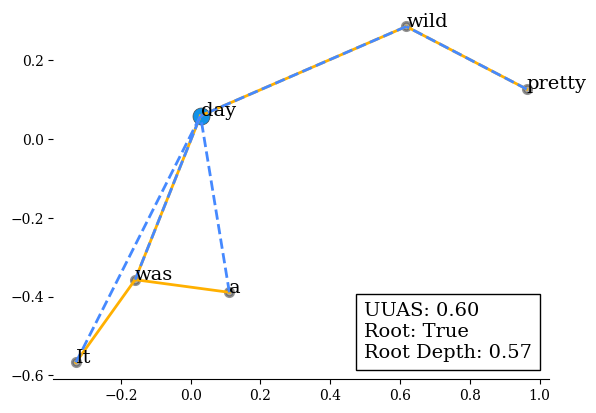

In [6]:
viz_pca = PCA(n_components=2).fit_transform(viz)
fig, ax = plotEuclidean(viz_pca, 
                        root_idx,
                        sentence,
                        gold_edges, 
                        pred_edges,
                        stop_words)
at = AnchoredText(f"UUAS: {uuas:.2f}\n" + 
                  f"Root: {root_acc}\n" +
                  f"Root Depth: {root_depth:.2f}",
                  frameon=True,
                  loc='lower right',
                  prop=dict(fontsize="14"),
                  )
ax.add_artist(at)
fig.show()